<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/LR_UQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What do we do:
We build a simple linear model to predict electricity consumption from 3 weather variables:
$$
y = \beta X+\epsilon  
$$

- $\boxed{\epsilon}$ is the **noise / irreducible randomness** usually $\sim \mathcal{N}(0,σ^2I)$.
-  $\boxed{\beta_0, \beta_1, \beta_2, \beta_3}$ are **model parameters**

## 1) Load and prepare data
- Download the dataset with `kagglehub.dataset_download(...)`
- Load the CSV & Choose one target column `y` and predictor columns `X`

## 2) Fit the regression model (OLS)

**Ordinary Least Squares - OLS reminder**

We choose the parameters $\beta$ that minimize the sum of squared errors:
$$
\hat{\beta}=\arg\min_{\beta}\ \sum_{i=1}^{n}\left(y_i-\mathbf{x}_i^\top\beta\right)^2
$$
where $\mathbf{x}_i=[1,\ x_{i1},\ x_{i2},\ x_{i3}]^\top$ includes the intercept.

A nice and convinient way to the estimate coefficients with OLS is:
$$
\hat\beta = (X^\top X)^{-1}X^\top y
$$
We evaluate with root mean square error (RMSE) on train and test.


---

## 3) Uncertainty characterization
### 3.a Aleatory (Gaussian residual model)
### 3.b Aleatory (non-parametric residual model)
---

### 3.c Epistemic uncertainty (analytic covariance)  
### 3.d Epistemic uncertainty (bootstrap)


In [5]:
# load packages
import os # operating system package
import glob # Unix style pathname pattern expansion
import kagglehub # useufl to import the data from Kaggle
import numpy as np # process data and numerical computing
import pandas as pd # tabular data package
import matplotlib.pyplot as plt # plot and visualize
import seaborn as sns  # plot and visualize from tables
import plotly.graph_objects as go  # interactive plots

## 1) Load and prepare data


**Description:**

We will load a file that contains the daily electricity consumption and weather features. Each row represents one day with the following:

- **date** - Date of observation
- **AWND** - Average daily wind speed (m/s)
- **PRCP** - Daily precipitation (mm)
- **TMAX** - Daily maximum temperature (°C)
- **TMIN** - Daily minimum temperature (°C)
- **daily_consumption** - Total daily electricity consumption

In [6]:
# =========================================================
# 1a) Colab setup: prepare Kaggle path where the dataset is
# =========================================================
# Download latest version
path = kagglehub.dataset_download("sudhirsingh27/electricity-consumption-based-on-weather-data")
print("Path to dataset files:", path)

# List files in the path
files = sorted(glob.glob(os.path.join(path, "**", "*"), recursive=True))
print("Files found in the path:")
for f in files:
    if os.path.isfile(f):
        print(" -", f)

Using Colab cache for faster access to the 'electricity-consumption-based-on-weather-data' dataset.
Path to dataset files: /kaggle/input/electricity-consumption-based-on-weather-data
Files found in the path:
 - /kaggle/input/electricity-consumption-based-on-weather-data/electricity_consumption_based_weather_dataset.csv


In [7]:
# =========================================================
# 1b) Load and process the data
# =========================================================

# Load first CSV found
csvs_files = sorted(glob.glob(os.path.join(path, "**", "*.csv"), recursive=True))
if len(csvs_files) == 0:
    raise FileNotFoundError("No CSV found in kagglehub dataset folder.")
csv_path = csvs_files[0]
print("Loading this CSV file:", csv_path)
df = pd.read_csv(csv_path)
print("Raw shape:", df.shape)
display(df.head(10))
print("\nColumns:", list(df.columns))


# --- Keep numeric columns  ---
df_num = df.select_dtypes(include=[np.number]).copy()
df_num['daily_consumption_previous_day'] = df_num['daily_consumption'].shift(1)
df_num = df_num.dropna().reset_index(drop=True)
print("Numeric-only shape:", df_num.shape)
display(df_num.head(10))


# --- prepare data for simple tutorial  ---
# Prefer y columns with these keywords; otherwise fallback to last numeric column

x_cols = ['daily_consumption_previous_day', 'PRCP', 'TMAX']  # the explainatory variables
y_col = 'daily_consumption'  # the target variables

# transform pandas tabular data into arrays
X_raw = df_num[x_cols].to_numpy()
y = df_num[y_col].to_numpy()

# Safely drop rows if NaNs or infs
mask = np.isfinite(y) & np.all(np.isfinite(X_raw), axis=1)
X_raw = X_raw[mask]
y = y[mask]

print("Final shapes -> X_raw:", X_raw.shape, "y:", y.shape)


Loading this CSV file: /kaggle/input/electricity-consumption-based-on-weather-data/electricity_consumption_based_weather_dataset.csv
Raw shape: (1433, 6)


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
0,2006-12-16,2.5,0.0,10.6,5.0,1209.176
1,2006-12-17,2.6,0.0,13.3,5.6,3390.460
2,2006-12-18,2.4,0.0,15.0,6.7,2203.826
3,2006-12-19,2.4,0.0,7.2,2.2,1666.194
4,2006-12-20,2.4,0.0,7.2,1.1,2225.748
5,2006-12-21,2.3,0.0,12.2,3.3,1716.624
6,2006-12-22,2.3,11.9,9.4,3.9,2341.338
7,2006-12-23,3.0,19.8,15.0,8.9,4773.386
8,2006-12-24,3.4,0.0,11.1,6.1,2550.012
9,2006-12-25,2.2,9.4,7.2,3.9,2743.120



Columns: ['date', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']
Numeric-only shape: (1417, 6)


,AWND,PRCP,TMAX,TMIN,daily_consumption,daily_consumption_previous_day
0,2.6,0.0,13.3,5.6,3390.460,1209.176
1,2.4,0.0,15.0,6.7,2203.826,3390.460
2,2.4,0.0,7.2,2.2,1666.194,2203.826
3,2.4,0.0,7.2,1.1,2225.748,1666.194
4,2.3,0.0,12.2,3.3,1716.624,2225.748
5,2.3,11.9,9.4,3.9,2341.338,1716.624
6,3.0,19.8,15.0,8.9,4773.386,2341.338
7,3.4,0.0,11.1,6.1,2550.012,4773.386
8,2.2,9.4,7.2,3.9,2743.120,2550.012
9,3.3,2.0,11.7,6.1,3934.110,2743.120


Final shapes -> X_raw: (1417, 3) y: (1417,)


we prepare $\mathbf{x}_i=[1,\ x_{i1},\ x_{i2},\ x_{i3}]^\top$ to include the intercept


Train shapes: (1133, 4) (1133,)
Test shapes : (284, 4) (284,)


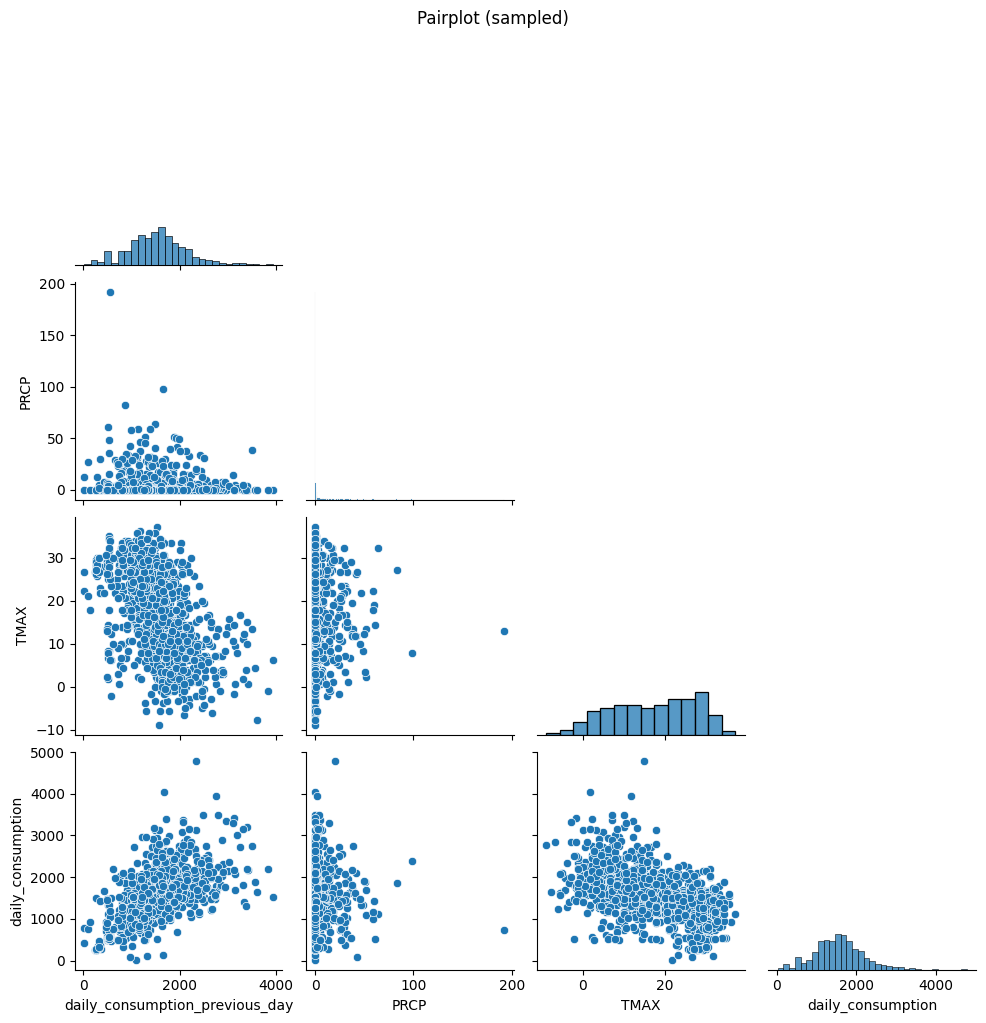

In [8]:
# Build design matrix (add intercept column)
n = len(y)
X = np.c_[np.ones((n, 1)), X_raw]  # (n, 4) = [1, x1, x2, x3]

# Train/test split
rng = np.random.default_rng(0)
perm = rng.permutation(n)
n_train = int(0.8 * n)
idx_train, idx_test = perm[:n_train], perm[n_train:]
X_train, y_train = X[idx_train], y[idx_train]
X_test, y_test = X[idx_test], y[idx_test]
X_raw_train = X_raw[idx_train]
X_raw_test = X_raw[idx_test]
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes :", X_test.shape, y_test.shape)

# Quick look at the data using pairplot matrix using seaborn
sample_n = min(1000, len(y))
sidx = rng.choice(len(y), size=sample_n, replace=False)
df_plot = pd.DataFrame(X_raw[sidx], columns=x_cols)
df_plot[y_col] = y[sidx]
sns.pairplot(df_plot, corner=True, diag_kind="hist")
plt.suptitle("Pairplot (sampled)", y=1.02)
plt.show()

## 2) Fit the regression model (OLS)
We know that the coefficients for OLS can be found solving this:

$$
\hat\beta = (X^\top X)^{-1}X^\top y
$$

This means we will solve a linear system in the form
$$
(X^\top X) \hat\beta = X^\top y
$$

Or simply:

$$
A \hat\beta = b
$$


In [9]:
# =========================================================
# 2a) Fit linear regression - use ordinary least square OLS
# =========================================================

# fit lineart model
A = X_train.T @ X_train
b = X_train.T @ y_train
beta_hat = np.linalg.solve(A, b) # numpy solver for linear programs

# predict and RMSE
yhat_train = X_train @ beta_hat # get predictions on the training set
yhat_test = X_test @ beta_hat # get predictions on the test set

rmse_train = float(np.sqrt(np.mean((y_train - yhat_train) ** 2))) # RMSE training
rmse_test = float(np.sqrt(np.mean((y_test - yhat_test) ** 2))) # RMSE test

# print
print("beta_hat:", beta_hat)
print("RMSE train:", rmse_train)
print("RMSE test :", rmse_test)

beta_hat: [ 1.17578249e+03  4.43343175e-01 -1.87246294e+00 -1.72846486e+01]
RMSE train: 454.46998705017745
RMSE test : 491.4915322787332


In [10]:
# =========================================================
# 2b) Add the fitted plane (y = bX) to the scatter plot data
#     using plotly.graph_objects as go (movable image)
#
# NOTE: With 3 predictors,
#               - We will show a 3D surface using two variables
#               - We will keep the 3rd fixed at its mean value
# =========================================================

b0, b1, b2, b3  = beta_hat
x1_name, x2_name, x3_name = x_cols[0], x_cols[1], x_cols[2]
x1, x2, x3 = X_raw[:,0], X_raw[:,1], X_raw[:,2]
x2_fixed = float(np.mean(x2))

# Grid for surface
x1g = np.linspace(x1.min(), x1.max(), 60)
x3g = np.linspace(x3.min(), x3.max(), 60)
X1g, X3g = np.meshgrid(x1g, x3g)
Yg = b0 + b1 * X1g + b2 * x2_fixed + b3 * X3g

# Subsample points for speed
sub = rng.choice(len(y), size=min(2500, len(y)), replace=False)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=x1[sub], y=x3[sub], z=y[sub],
    mode="markers",
    marker=dict(size=3, opacity=0.6),
    name="data"
))
fig.add_trace(go.Surface(
    x=X1g, y=X3g, z=Yg,
    opacity=0.5,
    showscale=False,
    name=f"OLS surface (x2 fixed at mean={x2_fixed:.3f})"
))
fig.update_layout(
    scene=dict(xaxis_title=x1_name, yaxis_title=x3_name, zaxis_title=y_col),
    width=900, height=650
)
fig.show()



## 3) Uncertainty characterization
### 3.a Aleatory (Parametric Gaussian residual model)

We now try to model $\epsilon$, the error distribution modelling variability in the data.

More data can improve the model, but data cannot remove the variability, hence it is  **characterized as ALEATORIC**



Residuals:
$$
r_i = y_i - \hat y_i
$$

Unbiased noise estimate:
$$
\hat\sigma^2 = \frac{1}{n-p}\sum r_i^2
$$

We visualize the residual histogram and a fitted $\epsilon\sim \mathcal{N}(0,\sigma^2)$.


**REMARK:**

Why dont we use `np.std(residual)`

👉 Because we must correct for the number of estimated parameters.

Note that `np.std(resid, ddof=p)` is equivalent


### 3.b Aleatory (non-parametric residual model)
We resample the residuals directly instead of assuming a Gaussian shape:
$$
r_i = y^{new}_i - \hat y_i
$$
This gives a non-parametric predictive distribution of the errors.

sigma_hat (Gaussian residual model): 455.27435933805833
Show bias:
standard deviation for p=1, 454.46998705017745
standard deviation for p=4, 455.27435933805833


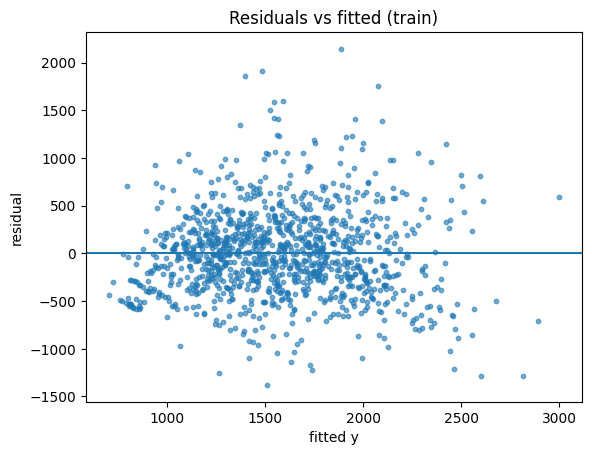

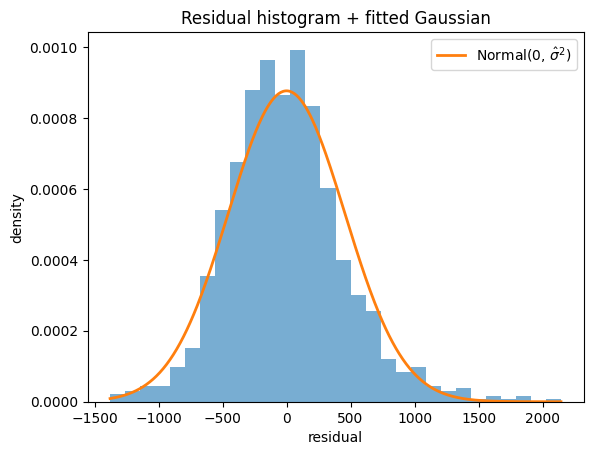

In [11]:
# =========================================================
# 3. START UNCERTAINTY CHARACTERIZATION
# 3.a) Aleatory uncertainty --> residuals assuming gaussian distribution
# =========================================================

resid = y_train - yhat_train
p = X_train.shape[1]  # parameters incl intercept
sigma2_hat = float((resid @ resid) / (len(y_train) - p))
sigma_hat = float(np.sqrt(sigma2_hat))
print("sigma_hat (Gaussian residual model):", sigma_hat)

# show bias Var(epsilon) estimator if p not accounted for
print('Show bias:')
print('standard deviation for p=1,', np.std(resid))
print(f'standard deviation for p={p},',np.std(resid, ddof=p))


# Residual diagnostics
plt.figure()
plt.scatter(yhat_train, resid, s=10, alpha=0.6)
plt.axhline(0)
plt.title("Residuals vs fitted (train)")
plt.xlabel("fitted y")
plt.ylabel("residual")
plt.show()


# Show predictive distributions
plt.figure()
counts, edges, _ = plt.hist(resid, bins=30, density=True, alpha=0.6)
xx = np.linspace(resid.min(), resid.max(), 400)
pdf = (1.0 / (np.sqrt(2*np.pi) * sigma_hat)) * np.exp(-0.5 * (xx / sigma_hat)**2) # equation for the gaussain PDF
plt.plot(xx, pdf, linewidth=2, label=r"Normal(0, $\hat\sigma^2$)")
plt.title("Residual histogram + fitted Gaussian")
plt.xlabel("residual")
plt.ylabel("density")
plt.legend()
plt.show()


Skewness: 0.5290221309665145
Excess Kurtosis: 1.3758034160529036
Shapiro-Wilk statistic: 0.981225999878034
Shapiro-Wilk p-value: 6.18583483003426e-11


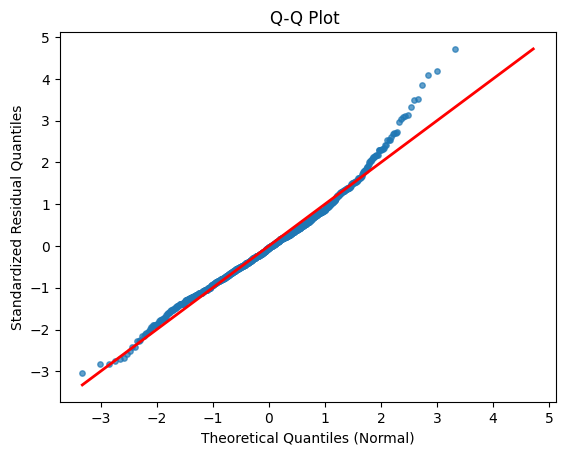

In [12]:


## A bit of DIAGNOSTIC:

# ARE THE RESIDUALS NORMAL DISTRIBUTED?


from scipy import stats
import statsmodels.api as sm

# MUST BE BOTH 0 for Gaussian
print("Skewness:", stats.skew(resid))
print("Excess Kurtosis:", stats.kurtosis(resid))

# Shapiro–Wilk tests:
# H0​:Residuals are normally distributed
stat, p_value = stats.shapiro(resid)
print("Shapiro-Wilk statistic:", stat)
print("Shapiro-Wilk p-value:", p_value)

# QQ plot
# H0​:Residuals are normally distributed

resid_sorted = np.sort(resid)# Sort residuals
n = len(resid_sorted)# Sample size

# Theoretical quantiles from standard normal
theoretical_q = stats.norm.ppf((np.arange(1, n + 1) - 0.5) / n)

# Standardize residuals (empirical spread of residual vector ddof=1)
resid_std = (resid_sorted - np.mean(resid_sorted)) / np.std(resid_sorted, ddof=1)

# Plot
plt.figure()
plt.scatter(theoretical_q, resid_std, s=15, alpha=0.7)

# add 45-degree reference line (target )
min_q = min(theoretical_q.min(), resid_std.min())
max_q = max(theoretical_q.max(), resid_std.max())
plt.plot([min_q, max_q], [min_q, max_q], color='red', linewidth=2)

plt.title("Q-Q Plot ")
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Standardized Residual Quantiles")
plt.show()

## 3.c) Epistemic uncertainty (Confidence Intervals on parameters)

Because we only have a finite dataset, the OLS estimate $\hat\beta$ is not a fixed number. It is a **uncertain quantitiy** that would change if we collected a different dataset (new measurements, different days).

More data can reduce this uncertainty, hence,it is **characterized as EPISTEMIC**

----
###  --> Confidence Intervals via analytic covariance
Under the i.i.d. Gaussian noise assumption, $\hat\beta$ is (approximately) Gaussian and its estimated covariance is:
$$
\widehat{\mathrm{Var}}(\hat\beta)= \hat\sigma^2  (X^\top X)^{-1}.
$$
with the estimated variance obtained from the training residuals:
$$
\hat\sigma^2 = \frac{1}{n-p}\sum_{i=1}^n (y_i-\hat y_i)^2,
$$
where $p$ is the number of parameters.

From this covariance matrix we can get:
- The **standard error** of coefficient $j$ is
 $$
  \mathrm{SE}(\hat\beta_j)=\sqrt{\left[\widehat{\mathrm{Var}}(\hat\beta)\right]_{jj}}.
$$
This is simply the square root of the j-th diagonal element


- A (approx.) **95% confidence interval** is
$$
  \hat\beta_j \pm z_{0.975}\,\mathrm{SE}(\hat\beta_j),
$$
  with $z_{0.975}\approx 1.96$.  

**Interpretation:** if we repeated “collect data + fit OLS” many times, about 95% of these intervals would contain the true coefficient $\beta_j$.


----
###  --> Confidence Intervals via bootstraping

The analytic formula above relies on assumptions (especially i.i.d. Gaussian noise and a correct linear model). The **bootstrap** is a data-driven alternative that estimates parameter uncertainty by *simulating repeated datasets* from the one we have.

**Pairs bootstrap (what we do):**
1. Sample rows $(x_i, y_i)$ from the training set **with replacement** (same number of rows as the original training set).
2. Fit OLS on this bootstrap dataset → obtain $\hat\beta^{(b)}$.
3. Repeat for $b=1,\dots,B$.

This produces many plausible coefficient values:
$$
\hat\beta^{(1)},\hat\beta^{(2)},\dots,\hat\beta^{(B)}.
$$
Their spread represents **epistemic uncertainty**. A simple **bootstrap confidence interval** (percentile method) for coefficient $j$ is:
$$
\left[\,Q_{0.025}(\hat\beta_j^{(b)}),\ Q_{0.975}(\hat\beta_j^{(b)})\,\right].
$$

**Why bootstrap is useful:** it is simple, intuitive “refit many times”, and can work well even when the distributional assumptions are not perfect.



In [13]:
## =========================================================
# 3.c) Epistemic uncertainty --> analytic covariance of beta_hat
# =========================================================

XtX_inv = np.linalg.inv(A)
cov_beta = sigma2_hat * XtX_inv
se_beta = np.sqrt(np.diag(cov_beta))

# get confidence interval via asymptotic approximation
z = 1.96
beta_ci_low = beta_hat - z * se_beta
beta_ci_high = beta_hat + z * se_beta

names = ["intercept"] + [f"beta_{c}" for c in x_cols]

print("\nAnalytic parameter uncertainty (approx 95% CI)")
for j, name in enumerate(names):
    print(f"{name:15s}: {beta_hat[j]: .6f}  (SE {se_beta[j]:.6f})  "
          f"CI [{beta_ci_low[j]:.6f}, {beta_ci_high[j]:.6f}]")



Analytic parameter uncertainty (approx 95% CI)
intercept      :  1175.782487  (SE 64.207108)  CI [1049.936555, 1301.628419]
beta_daily_consumption_previous_day:  0.443343  (SE 0.027063)  CI [0.390300, 0.496386]
beta_PRCP      : -1.872463  (SE 1.236504)  CI [-4.296012, 0.551086]
beta_TMAX      : -17.284649  (SE 1.607709)  CI [-20.435758, -14.133539]


In [14]:
cov_beta

array([[ 4.12255272e+03, -1.57537340e+00, -1.29529940e+01,
        -8.28647070e+01],
       [-1.57537340e+00,  7.32390885e-04,  2.98552515e-03,
         2.42519374e-02],
       [-1.29529940e+01,  2.98552515e-03,  1.52894319e+00,
         1.42554945e-01],
       [-8.28647070e+01,  2.42519374e-02,  1.42554945e-01,
         2.58472820e+00]])


Bootstrap parameter uncertainty (95% percentile CI)
intercept      : mean= 1168.562888  CI [1015.100458, 1315.920372]
beta_daily_consumption_previous_day: mean= 0.446873  CI [0.389302, 0.514920]
beta_PRCP      : mean=-1.825395  CI [-4.004559, 0.837274]
beta_TMAX      : mean=-17.184115  CI [-20.453690, -13.753011]


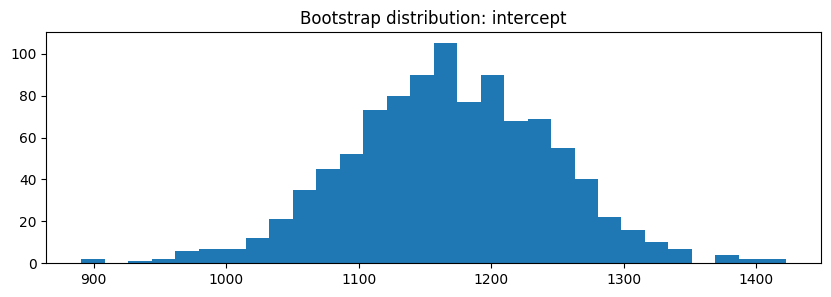

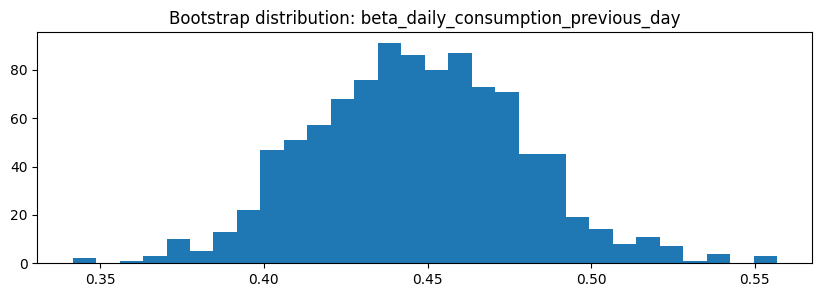

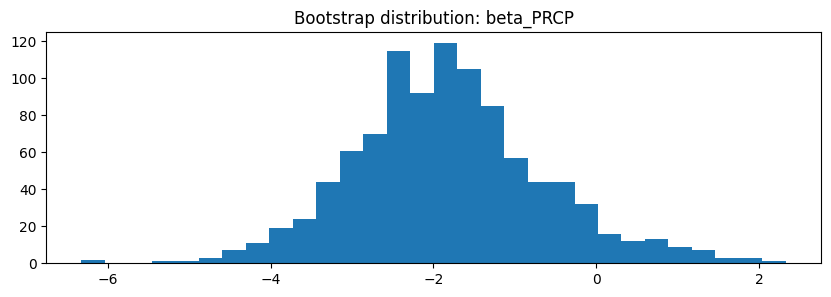

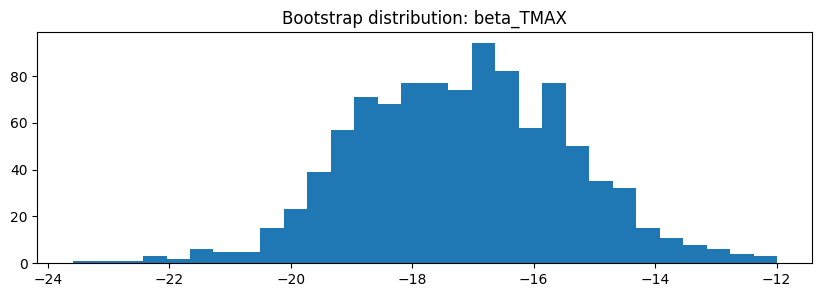

In [15]:
# =========================================================
# 3.d) Epistemic uncertainty --> bootstrap CI for the parameters beta_hat
# =========================================================

B = 1000  # number of times we will repeat the fitting
beta_boot = np.zeros((B, X_train.shape[1]))
ntr = len(y_train)

for b in range(B): # repeat fitting many times
    ib = rng.integers(0, ntr, size=ntr) # random integer for row selection
    Xb = X_train[ib] # random subset of X
    yb = y_train[ib] # random subset of y
    beta_boot[b] = np.linalg.solve(Xb.T @ Xb, Xb.T @ yb)

boot_low = np.quantile(beta_boot, 0.025, axis=0)
boot_high = np.quantile(beta_boot, 0.975, axis=0)

print("\nBootstrap parameter uncertainty (95% percentile CI)")
for j, name in enumerate(names):
    print(f"{name:15s}: mean={beta_boot[:,j].mean(): .6f}  "
          f"CI [{boot_low[j]:.6f}, {boot_high[j]:.6f}]")

# Optional: show bootstrap histograms
for j, name in enumerate(names):
    plt.figure(figsize=(10, 3))
    plt.hist(beta_boot[:, j], bins=30)
    plt.title(f"Bootstrap distribution: {name}")
    plt.show()

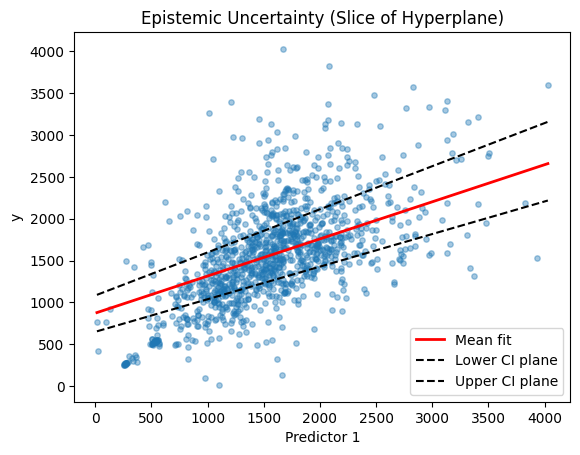

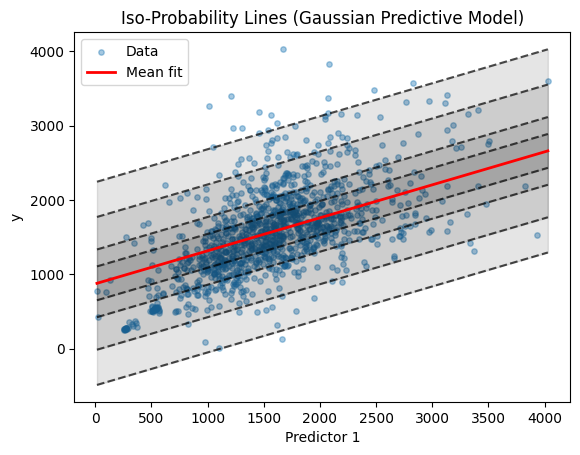

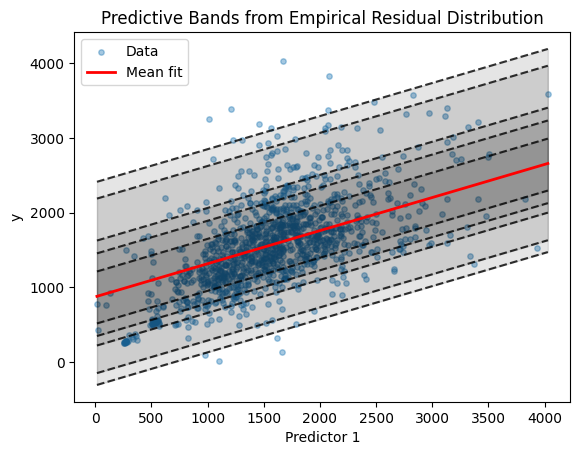

In [32]:
# =========================================================
# Visualize uncertainty
# =========================================================

j = 1   # index of variable (excluding intercept)
xj = X_train[:, j]
xj_grid = np.linspace(xj.min(), xj.max(), 200)

# Start from mean design vector
x_mean = X_train.mean(axis=0)

# Build grid design matrix
X_grid = np.tile(x_mean, (len(xj_grid), 1))
X_grid[:, j] = xj_grid

y_mean  = X_grid @ beta_hat
y_low   = X_grid @ boot_low
y_high  = X_grid @ boot_high

plt.figure()
plt.scatter(X_train[:, j], y_train, s=15, alpha=0.4)
plt.plot(xj_grid, y_mean, linewidth=2, c='r', label="Mean fit")
plt.plot(xj_grid, y_low, linestyle="--", c='k', label="Lower CI plane")
plt.plot(xj_grid, y_high, linestyle="--", c='k', label="Upper CI plane")

plt.xlabel(f"Predictor {j}")
plt.ylabel("y")
plt.title("Epistemic Uncertainty (Slice of Hyperplane)")
plt.legend()
plt.show()



# Aleatory (residual) predictive band
plt.figure()
plt.scatter(X_train[:, j], y_train, s=15, alpha=0.4, label="Data")# Scatter data
plt.plot(xj_grid, y_mean, linewidth=2, c='r', label="Mean fit")
levels = [0.5, 1.0, 1.96, 3.0] # Iso-probability levels

for k in levels:
    y_upper = y_mean + k * sigma_hat
    y_lower = y_mean - k * sigma_hat
    plt.plot(xj_grid, y_upper, linestyle="--", c='k', alpha=0.7)
    plt.plot(xj_grid, y_lower, linestyle="--", c='k', alpha=0.7)

    plt.fill_between(xj_grid,
                    y_lower,
                    y_upper,
                    alpha=0.1,
                    color='k')

plt.xlabel(f"Predictor {j}")
plt.ylabel("y")
plt.title("Iso-Probability Lines (Gaussian Predictive Model)")
plt.legend()
plt.show()


plt.figure()
plt.scatter(X_train[:, j], y_train, s=15, alpha=0.4, label="Data")
plt.plot(xj_grid, y_mean, linewidth=2, c='r', label="Mean fit")

# Residual quantile levels
percentile_levels = [0.8, 0.9, 0.95, 0.99, 0.995]
for pl in percentile_levels:
    y_qU = y_mean + np.quantile(resid, pl)
    plt.plot(xj_grid, y_qU, linestyle="--",  c='k', alpha=0.8)
    y_qL = y_mean + np.quantile(resid, 1.0-pl)
    plt.plot(xj_grid, y_qL, linestyle="--", c='k', alpha=0.8)

    plt.fill_between(xj_grid,
                     y_qL,
                     y_qU,
                     alpha=0.1,
                     color='k')

plt.xlabel(f"Predictor {j}")
plt.ylabel("y")
plt.title("Predictive Bands from Empirical Residual Distribution")
plt.legend()
plt.show()
